In [68]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)
print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.6.0


In [69]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))
    
    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))
    
    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))
        
    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

In [74]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
        
        self.image_dirs = image_dirs
        self.transform = transform
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
            
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)
            
            
            

In [75]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [76]:
train_dirs = {
    'normal' : 'COVID-19 Radiography Database/normal',
    'viral' : 'COVID-19 Radiography Database/viral',
    'covid' : 'COVID-19 Radiography Database/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 201 covid examples


In [77]:
test_dirs = {
    'normal' : 'COVID-19 Radiography Database/test/normal',
    'viral' : 'COVID-19 Radiography Database/test/viral',
    'covid' : 'COVID-19 Radiography Database/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [78]:
batch_size = 6

dl_train  = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 472
Number of test batches 15


In [79]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i+1, xticks=[], yticks=[])
        image = image.numpy().transpose((1,2,0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if(preds[i] != labels[i]):
            col = 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    
    plt.tight_layout()
    plt.show()


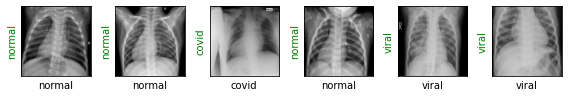

In [80]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

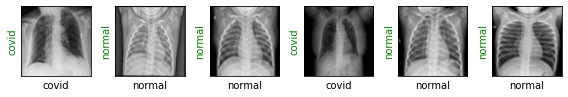

In [81]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

In [108]:
resnet50 = torchvision.models.resnet50(pretrained=True)

print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [109]:
resnet50.fc = torch.nn.Linear(in_features = 2048, out_features = 3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr = 3e-5)

In [110]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

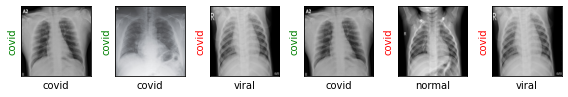

In [111]:
show_preds()

In [115]:
def train(epochs):
    print('Starting training .......')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)
        
        train_loss = 0
        val_loss = 0
        
        resnet50.train()   #Setting model to training phase
        
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)
                
                accuracy = 0
                
                resnet50.eval()    #Setting model to evaluate phase
                
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())
                
                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
                
                show_preds()
                
                resnet50.train()
                
                if accuracy >= 0.98 and val_loss <= 0.11:
                    print('Performance condition satisfied, stopping...')
                    return
            
            train_loss /= (train_step + 1)
            
            print(f'Training loss: {train_loss:.4f}')
        print('Training Complete.....')

Starting training .......
Starting epoch 1/1
Evaluating at step 0
Validation loss: 1.1108, Accuracy: 0.4667


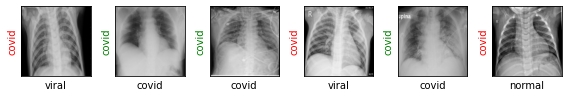

Training loss: 1.5124
Training loss: 1.2900
Training loss: 0.7983
Training loss: 0.5069
Training loss: 0.3068
Training loss: 0.1785
Training loss: 0.1465
Training loss: 0.1181
Training loss: 0.1094
Training loss: 0.1090
Training loss: 0.0732
Training loss: 0.0617
Training loss: 0.0796
Training loss: 0.0727
Training loss: 0.0425
Training loss: 0.0522
Training loss: 0.0430
Training loss: 0.0510
Training loss: 0.0387
Training loss: 0.0326
Evaluating at step 20
Validation loss: 0.7068, Accuracy: 0.8000


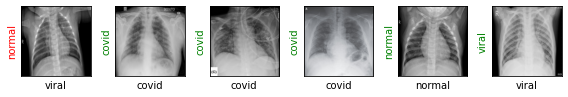

Training loss: 0.0360
Training loss: 0.0275
Training loss: 0.0255
Training loss: 0.0135
Training loss: 0.0187
Training loss: 0.0377
Training loss: 0.0191
Training loss: 0.0167
Training loss: 0.0144
Training loss: 0.0315
Training loss: 0.0264
Training loss: 0.0132
Training loss: 0.0166
Training loss: 0.0131
Training loss: 0.0088
Training loss: 0.0088
Training loss: 0.0129
Training loss: 0.0202
Training loss: 0.0057
Training loss: 0.0139
Evaluating at step 40
Validation loss: 0.3495, Accuracy: 0.9222


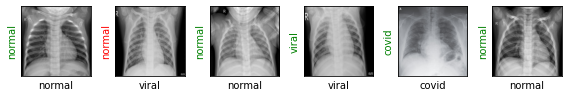

Training loss: 0.0108
Training loss: 0.0102
Training loss: 0.0165
Training loss: 0.0223
Training loss: 0.0134
Training loss: 0.0118
Training loss: 0.0109
Training loss: 0.0086
Training loss: 0.0027
Training loss: 0.0030
Training loss: 0.0109
Training loss: 0.0060
Training loss: 0.0095
Training loss: 0.0039
Training loss: 0.0038
Training loss: 0.0041
Training loss: 0.0054
Training loss: 0.0106
Training loss: 0.0157
Training loss: 0.0054
Evaluating at step 60
Validation loss: 0.2456, Accuracy: 0.9333


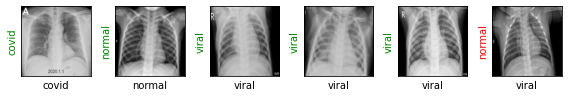

Training loss: 0.0019
Training loss: 0.0037
Training loss: 0.0053
Training loss: 0.0140
Training loss: 0.0018
Training loss: 0.0174
Training loss: 0.0021
Training loss: 0.0014
Training loss: 0.0031
Training loss: 0.0141
Training loss: 0.0084
Training loss: 0.0021
Training loss: 0.0012
Training loss: 0.0061
Training loss: 0.0015
Training loss: 0.0108
Training loss: 0.0054
Training loss: 0.0013
Training loss: 0.0062
Training loss: 0.0064
Evaluating at step 80
Validation loss: 0.2488, Accuracy: 0.9222


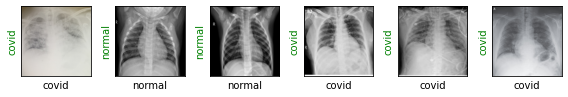

Training loss: 0.0010
Training loss: 0.0022
Training loss: 0.0016
Training loss: 0.0010
Training loss: 0.0021
Training loss: 0.0015
Training loss: 0.0011
Training loss: 0.0047
Training loss: 0.0043
Training loss: 0.0014
Training loss: 0.0039
Training loss: 0.0076
Training loss: 0.0049
Training loss: 0.0006
Training loss: 0.0008
Training loss: 0.0026
Training loss: 0.0033
Training loss: 0.0017
Training loss: 0.0037
Training loss: 0.0041
Evaluating at step 100
Validation loss: 0.2595, Accuracy: 0.9111


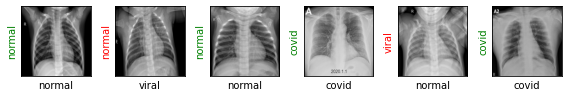

Training loss: 0.0006
Training loss: 0.0020
Training loss: 0.0024
Training loss: 0.0018
Training loss: 0.0035
Training loss: 0.0015
Training loss: 0.0129
Training loss: 0.0009
Training loss: 0.0071
Training loss: 0.0076
Training loss: 0.0026
Training loss: 0.0020
Training loss: 0.0013
Training loss: 0.0007
Training loss: 0.0009
Training loss: 0.0005
Training loss: 0.0012
Training loss: 0.0034
Training loss: 0.0004
Training loss: 0.0012
Evaluating at step 120
Validation loss: 0.2573, Accuracy: 0.9000


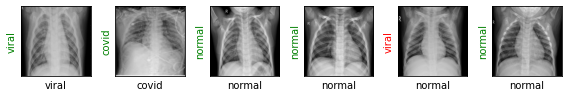

Training loss: 0.0008
Training loss: 0.0008
Training loss: 0.0031
Training loss: 0.0034
Training loss: 0.0004
Training loss: 0.0009
Training loss: 0.0054
Training loss: 0.0013
Training loss: 0.0039
Training loss: 0.0108
Training loss: 0.0062
Training loss: 0.0024
Training loss: 0.0008
Training loss: 0.0004
Training loss: 0.0015
Training loss: 0.0011
Training loss: 0.0015
Training loss: 0.0027
Training loss: 0.0053
Training loss: 0.0009
Evaluating at step 140
Validation loss: 0.2277, Accuracy: 0.9333


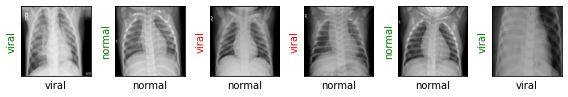

Training loss: 0.0019
Training loss: 0.0011
Training loss: 0.0033
Training loss: 0.0017
Training loss: 0.0007
Training loss: 0.0003
Training loss: 0.0013
Training loss: 0.0006
Training loss: 0.0019
Training loss: 0.0024
Training loss: 0.0039
Training loss: 0.0030
Training loss: 0.0004
Training loss: 0.0008
Training loss: 0.0010
Training loss: 0.0007
Training loss: 0.0009
Training loss: 0.0003
Training loss: 0.0006
Training loss: 0.0007
Evaluating at step 160
Validation loss: 0.1740, Accuracy: 0.9222


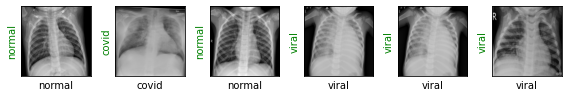

Training loss: 0.0002
Training loss: 0.0007
Training loss: 0.0017
Training loss: 0.0016
Training loss: 0.0007
Training loss: 0.0006
Training loss: 0.0002
Training loss: 0.0006
Training loss: 0.0003
Training loss: 0.0004
Training loss: 0.0015
Training loss: 0.0019
Training loss: 0.0002
Training loss: 0.0022
Training loss: 0.0001
Training loss: 0.0022
Training loss: 0.0010
Training loss: 0.0006
Training loss: 0.0004
Training loss: 0.0029
Evaluating at step 180
Validation loss: 0.2044, Accuracy: 0.9222


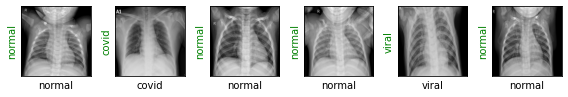

Training loss: 0.0004
Training loss: 0.0009
Training loss: 0.0023
Training loss: 0.0001
Training loss: 0.0006
Training loss: 0.0053
Training loss: 0.0072
Training loss: 0.0001
Training loss: 0.0007
Training loss: 0.0015
Training loss: 0.0001
Training loss: 0.0002
Training loss: 0.0003
Training loss: 0.0002
Training loss: 0.0002
Training loss: 0.0002
Training loss: 0.0001
Training loss: 0.0010
Training loss: 0.0002
Training loss: 0.0008
Evaluating at step 200
Validation loss: 0.3123, Accuracy: 0.8778


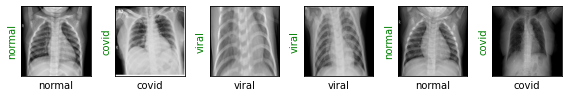

Training loss: 0.0009
Training loss: 0.0009
Training loss: 0.0029
Training loss: 0.0002
Training loss: 0.0046
Training loss: 0.0002
Training loss: 0.0009
Training loss: 0.0013
Training loss: 0.0043
Training loss: 0.0005
Training loss: 0.0033
Training loss: 0.0004
Training loss: 0.0009
Training loss: 0.0007
Training loss: 0.0002
Training loss: 0.0002
Training loss: 0.0008
Training loss: 0.0002
Training loss: 0.0009
Training loss: 0.0006
Evaluating at step 220
Validation loss: 0.2007, Accuracy: 0.9333


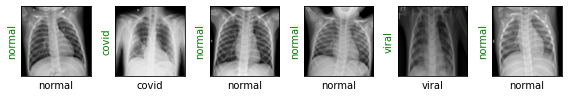

Training loss: 0.0001
Training loss: 0.0024
Training loss: 0.0003
Training loss: 0.0017
Training loss: 0.0023
Training loss: 0.0004
Training loss: 0.0012
Training loss: 0.0025
Training loss: 0.0019
Training loss: 0.0001
Training loss: 0.0006
Training loss: 0.0002
Training loss: 0.0013
Training loss: 0.0002
Training loss: 0.0010
Training loss: 0.0007
Training loss: 0.0006
Training loss: 0.0002
Training loss: 0.0009
Training loss: 0.0002
Evaluating at step 240
Validation loss: 0.1474, Accuracy: 0.9333


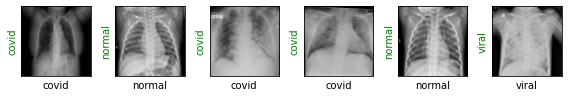

Training loss: 0.0001
Training loss: 0.0004
Training loss: 0.0001
Training loss: 0.0006
Training loss: 0.0012
Training loss: 0.0027
Training loss: 0.0003
Training loss: 0.0040
Training loss: 0.0006
Training loss: 0.0008
Training loss: 0.0037
Training loss: 0.0004
Training loss: 0.0004
Training loss: 0.0005
Training loss: 0.0003
Training loss: 0.0039
Training loss: 0.0002
Training loss: 0.0007
Training loss: 0.0001
Training loss: 0.0008
Evaluating at step 260
Validation loss: 0.1074, Accuracy: 0.9889


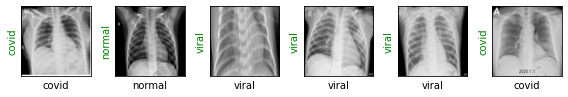

Performance condition satisfied, stopping...
CPU times: user 31min 2s, sys: 12.5 s, total: 31min 14s
Wall time: 15min 46s


In [113]:
%%time

train(epochs = 1)

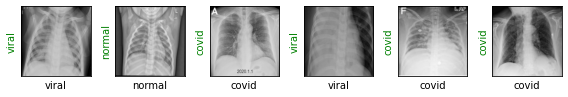

In [114]:
show_preds()
